In [1]:
import datetime as dt
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')
from pymongo import MongoClient

%matplotlib inline

In [2]:
connection_string = 'mongodb://connection:string' # mud
db = MongoClient(connection_string)['camara']

In [4]:
q = db.parlamentares.aggregate([
    {
        '$unwind': '$mandatos' # para separar cada legislatura em diferentes documentos
    },{
        '$group': {
            '_id': '$mandatos.legislatura',
            'total': {'$sum': 1}
        }
    }
])

list(q)

[{'_id': 52, 'total': 626},
 {'_id': 54, 'total': 671},
 {'_id': 53, 'total': 636},
 {'_id': 55, 'total': 604}]

In [22]:
q = db.parlamentares.aggregate([
    {
        '$unwind': '$mandatos'
    },
    {
        '$project': {
            '_id': 0,
            'legislatura': '$mandatos.legislatura',
            'homem': {'$cond': {'if': {'$eq': ['$sexo', 'M']}, 'then': 1, 'else': 0}},
        }
    },
    {
        '$group': {
            '_id': '$legislatura',
            'pct_homens': {'$avg': '$homem'},
        }
    },
    {
        '$sort': {'_id': 1}
    }
])

generos = pd.DataFrame(list(q))
generos.set_index('_id', inplace=True)
generos['pct_mulheres'] = 1 - generos.pct_homens

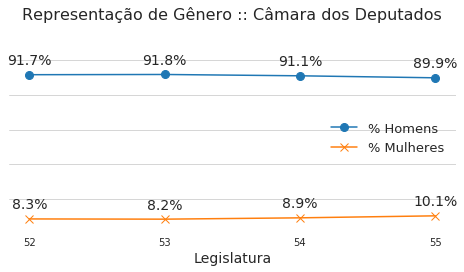

In [23]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(8, 3.5))
generos.plot(ax=ax, style=['o-', 'x-'], ms=8)
ax.legend(labels=['% Homens', '% Mulheres'], fontsize=13)

ax.set_xticks(generos.index)
ax.set_xlabel('Legislatura', size=14)

ax.set_ylim(0, 1.1)
ax.set_yticklabels('')

for index, row in generos.iterrows():
    ax.text(index, row.pct_homens + 0.06, '{:0.1f}%'.format(row.pct_homens*100), ha='center', size=14)
    ax.text(index, row.pct_mulheres + 0.06, '{:0.1f}%'.format(row.pct_mulheres*100), ha='center', size=14)
    
ax.set_title('Representação de Gênero :: Câmara dos Deputados\n', size=16)

sns.despine(left=True, bottom=True)
ax.xaxis.grid(False)

plt.savefig('genero2.png', bbox_inches='tight')

In [143]:
q = db.parlamentares.aggregate([
    {
        '$unwind': '$mandatos'
    },
    {
        '$project': {
            '_id': 0,
            'sexo': 1,
            'legislatura': '$mandatos.legislatura',
            'idade': {'$floor': {'$divide': [{'$subtract': ['$mandatos.dataInicio', '$dataNascimento']}, 1000*60*60*24*365]}},
        }
    },
    {
        '$group': {
            '_id': '$legislatura',
            'media_etaria': {'$avg': '$idade'},
            'desvio': {'$stdDevPop': '$idade'}
        }
    },{
        '$sort': {'_id': 1}
    }
])

idades = pd.DataFrame(list(q))
idades

,_id,desvio,media_etaria
0,52,9.870822,50.298722
1,53,10.877057,51.116352
2,54,11.362555,51.472429
3,55,12.030741,51.079470


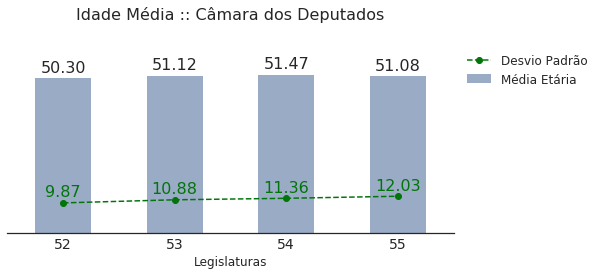

In [161]:
fig, ax = plt.subplots(figsize=(8, 3.5))

idades.media_etaria.plot.bar(ax=ax, color='#37598e', rot=0, alpha=0.5, label='Média Etária')
idades.desvio.plot(ax=ax, color='#02750a', ls='--', marker='.', ms=12, label='Desvio Padrão')
ax.legend(loc=(1.02, 0.75), fontsize=12)

ax.set_ylim(0, idades.media_etaria.max()*1.2)
ax.set_yticklabels("")

ax.set_xticklabels(idades._id, size=14)
ax.set_xlabel('Legislaturas', size=12)

for index, row in idades.iterrows():
    ax.text(index, row.media_etaria + 2, '{:.2f}'.format(row.media_etaria), ha='center', size=16)
    ax.text(index, row.desvio + 2, '{:.2f}'.format(row.desvio), ha='center', size=16, color='#02750a')
    
ax.set_title('Idade Média :: Câmara dos Deputados\n', size=16)

sns.despine(left=True)

plt.savefig('idade.png', bbox_inches='tight')

In [10]:
q = db.parlamentares.aggregate([
    {
        '$unwind': '$mandatos'
    },
    {
        '$project': {
            '_id': 0,
            'legislatura': '$mandatos.legislatura',
            'idade': {'$floor': {'$divide': [{'$subtract': ['$mandatos.dataInicio', '$dataNascimento']}, 1000*60*60*24*365]}},
        }
    }
])

b = pd.DataFrame(list(q))
b.head()

,idade,legislatura
0,52.0,55
1,54.0,53
2,58.0,54
3,54.0,53
4,58.0,54


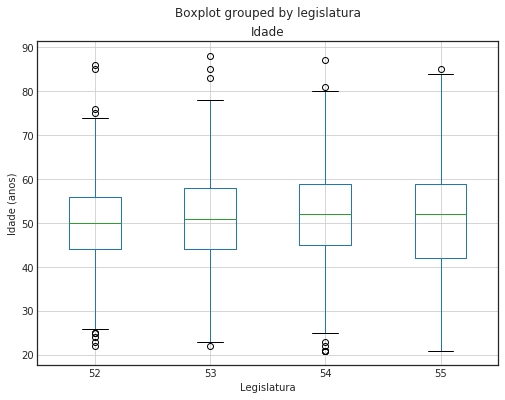

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
b.boxplot(by='legislatura', ax=ax)
ax.set_title('Idade')
ax.set_xlabel("Legislatura")
ax.set_ylabel('Idade (anos)')
plt.savefig('box.png', bbox_inches='tight')